DETECCIÓN DE ANOMALIAS

By Elías Jesús Ventura-Molina


Ejemplo obtenido de: [Enlace](https://www.youtube.com/watch?v=aLcDJoG0pec)

---


En en este ejemplo se crea un autoenconder para la detección de anomalias en transacciones bancarias. El encoder lo forma , una capa de 29 , una capa de 20 y otra de 14 , resultando un coder de 14 , el decoder es de una capa de 14, otra de 20 y una capa de 29.

El dataset se llama "creditcard" [mas información](https://www.openml.org/d/1597)

La red es entrenada con los datos "sin fraudes" , una vez que esta entrenada con ellos, se evalua el modelo con todo el conjunto de datos, donde clasifica como fraude a los valores que muestran una distancia entre el valor de entrada y el de salida mayor a un bias fijo.


# 1. Lectura en el set de datos

In [ ]:
#Librerias Requeridas
import pandas as pd
import matplotlib.pyplot as plt

# Se lee el dataset
datos = pd.read_csv("creditcard.csv")
# Ejemplo de algunos datos
print(datos.head())

#Se muestra información de la clases
nr_clases = datos['Class'].value_counts(sort=True)
print(nr_clases)

   Time        V1        V2        V3  ...       V27       V28  Amount  Class
0     0 -1.359807 -0.072781  2.536347  ...  0.133558 -0.021053  149.62    0.0
1     0  1.191857  0.266151  0.166480  ... -0.008983  0.014724    2.69    0.0
2     1 -1.358354 -1.340163  1.773209  ... -0.055353 -0.059752  378.66    0.0
3     1 -0.966272 -0.185226  1.792993  ...  0.062723  0.061458  123.50    0.0
4     2 -1.158233  0.877737  1.548718  ...  0.219422  0.215153   69.99    0.0

[5 rows x 31 columns]
0.0    21791
1.0       86
Name: Class, dtype: int64


# 2. Análisis exploratorio de  los datos 

Esta sección muestra información sobre el conjunto datos, con fines de que se conozca graficamente la composición del banco de datos

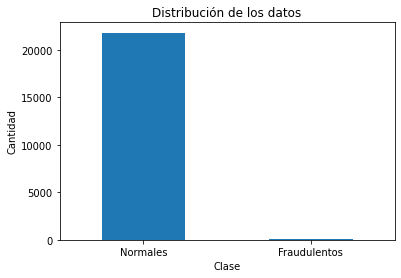

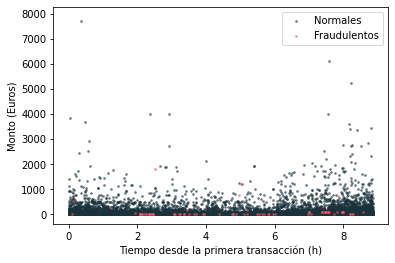

In [ ]:
# Cantidad de registros normales vs. fraudulentos
nr_clases.plot(kind = 'bar', rot=0)
plt.xticks(range(2), ['Normales', 'Fraudulentos'])
plt.title("Distribución de los datos")
plt.xlabel("Clase")
plt.ylabel("Cantidad")
plt.show()

# Monto de las transacciones vs. tiempo
normales = datos[datos.Class==0]
fraudulentos = datos[datos.Class==1]
plt.scatter(normales.Time/3600, normales.Amount, 
	alpha = 0.5, c='#19323C', label='Normales', s=3)
plt.scatter(fraudulentos.Time/3600, fraudulentos.Amount, 
	alpha = 0.5, c='#F2545B', label='Fraudulentos', s=3)
plt.xlabel('Tiempo desde la primera transacción (h)')
plt.ylabel('Monto (Euros)')
plt.legend(loc='upper right')
plt.show()





# 3. Pre-Procesamiento

In [ ]:
# Como La variable "Tiempo" no aporta información. La eliminaremos
from sklearn.preprocessing import StandardScaler
datos.drop(['Time'], axis=1, inplace=True)

#Se Normaliza el capo amount , para que quede en valores similares a los otros campos
datos['Amount'] = StandardScaler().fit_transform(datos['Amount'].values.reshape(-1,1))


In [ ]:
#Libreria requerida
from sklearn.model_selection import train_test_split

# Se divide el conjunto en set de entrenamiento y prueba
# Hold Out  80 -20
X_train, X_test = train_test_split(datos, test_size=0.2, random_state=42)

# La idea es que la red contenga solo datos "sin fraude" para que aprenda con ellos
X_train = X_train[X_train.Class == 0]
X_train = X_train.drop(['Class'], axis=1)
X_train = X_train.values

# Para validacion se genera un set datos de ambas clases
Y_test = X_test['Class']

# Y para prueba se genera un set solo con datos "sin fraude" para la red siga apegada a datos normales
X_test = X_test.drop(['Class'], axis=1)
X_test = X_test.values

# 4. DISEÑO DEL AUTOENCODER

In [ ]:

# 
import numpy as np
np.random.seed(5)
from keras.models import Model, load_model
from keras.layers import Input, Dense

## CARACTERISTICAS DEL AUTOENCONDER 

#La dimension de entrada es la cantidad de atributos del patron
dim_entrada = X_train.shape[1]          # 29
capa_entrada = Input(shape=(dim_entrada,))

# ENCODER
# Capa de 20 con funcion tangente
encoder = Dense(20, activation='tanh')(capa_entrada)
# Capa de 14 con funcion relu
encoder = Dense(14, activation='relu')(encoder)

# DECODER
# Capa de 20 con funcion tangente
decoder = Dense(20, activation='tanh')(encoder)
# Capa de 14 con funcion relu
decoder = Dense(29, activation='relu')(decoder)



# 5. EJECUCIÓN DEL AUTOENCODER

In [ ]:

#Se crea el modelo con las caracteristicas anteriormente descritas
autoencoder = Model(inputs=capa_entrada, outputs=decoder)

# Configuraremos nuestro modelo para usar una funcion error cuadratico medio y el optimizador descenso de gradiente estocástico
from keras.optimizers import SGD
sgd = SGD(lr=0.01)
autoencoder.compile(optimizer='sgd', loss='mse')


In [ ]:

epocas = 100
tam_lote = 32
autoencoder.fit(X_train, X_train, epochs=epocas, batch_size=tam_lote, shuffle=True, validation_data=(X_test,X_test), verbose=1)

Epoch 1/100
545/545 [==============================] - 1s 2ms/step - loss: 1.1114 - val_loss: 1.2773
Epoch 2/100
545/545 [==============================] - 1s 1ms/step - loss: 1.0225 - val_loss: 1.2337
Epoch 3/100
545/545 [==============================] - 1s 1ms/step - loss: 0.9886 - val_loss: 1.2043
Epoch 4/100
545/545 [==============================] - 1s 1ms/step - loss: 0.9628 - val_loss: 1.1791
Epoch 5/100
545/545 [==============================] - 1s 1ms/step - loss: 0.9394 - val_loss: 1.1560
Epoch 6/100
545/545 [==============================] - 1s 1ms/step - loss: 0.9207 - val_loss: 1.1390
Epoch 7/100
545/545 [==============================] - 1s 1ms/step - loss: 0.9066 - val_loss: 1.1256
Epoch 8/100
545/545 [==============================] - 1s 1ms/step - loss: 0.8953 - val_loss: 1.1147
Epoch 9/100
545/545 [==============================] - 1s 1ms/step - loss: 0.8858 - val_loss: 1.1053
Epoch 10/100
545/545 [==============================] - 1s 1ms/step - loss: 0.8777 - val_lo

# 6. VALIDACIÓN

In [ ]:
 
# Predicción X_test -> Autoencoder -> X_pred
X_pred = autoencoder.predict(X_test)

# Se obtiene las distancias entre el valor de entrada y el de salida
ecm = np.mean(np.power(X_test-X_pred,2), axis=1)

# Clasifica a los valeres que sobrepassen el umbral
umbral_fijo = 0.75
Y_pred = [1 if e > umbral_fijo else 0 for e in ecm]

#Matriz de confusión
from sklearn.metrics import confusion_matrix
conf_matrix = confusion_matrix(Y_test, Y_pred)
print("Matriz de confusion")
print(conf_matrix)

print("TP: Normal detectado como normal")
print("FN: Normal detectado como fraude")
print("TN: Fraude detectado como fraude")
print("FP: Fraude detectado como normal")

Matriz de confusion
[[3676  687]
 [   1   12]]
TP: Normal detectado como normal
FN: Normal detectado como fraude
TN: Fraude detectado como fraude
FP: Fraude detectado como normal
